# ssvep_select-clean_data

This python notebook is used to clean up and reformat the data generated from [ssvep_select.py](ssvep_select.py)

The code looks for the small gaps in the `stim` column due to the lag in keyboard input, and creates a new column at the end called `filled_stim`.

It is necessary to specify the file path of the original data file, and the output will will be saved under the same directory with the same file name, but with a suffix of `_cleaned`.

When decoding, please use the raw EEG channels`Fz`, `C3`, `Cz`, `C4`, `Pz`, `PO7`, `Oz`, `PO8` or the filtered EEG channels `Fz_filt`, `C3_filt`, `Cz_filt`, `C4_filt`, `Pz_filt`, `PO7_filt`, `Oz_filt`, `PO8_filt` as input data, and use `filled_stim` as labels.

In [9]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

file_path = r'~\.eegnb\data\ssvep_select\local\unicorn\subject0003\session000\recording_2024-04-26-02.38.53.csv'
df = pd.read_csv(file_path)

df.insert(loc=1, column='converted_timestamps', value=pd.to_datetime(df['timestamps'], unit='s'))

print(df.head())

     timestamps          converted_timestamps             Fz             C3  \
0  1.714099e+09 2024-04-26 02:39:06.160583496  205389.562500  201455.750000   
1  1.714099e+09 2024-04-26 02:39:06.163166046  205382.406250  201456.468750   
2  1.714099e+09 2024-04-26 02:39:06.165611267  205381.421875  201453.593750   
3  1.714099e+09 2024-04-26 02:39:06.170563936  205392.062500  201454.671875   
4  1.714099e+09 2024-04-26 02:39:06.173181295  205399.406250  201462.093750   

              Cz             C4             Pz            PO7             Oz  \
0  212838.156250  255266.671875  199957.109375  197287.593750  201910.375000   
1  212832.781250  255252.109375  199947.453125  197288.484375  201917.265625   
2  212831.796875  255248.531250  199943.609375  197283.218750  201910.921875   
3  212839.125000  255255.765625  199951.921875  197279.718750  201899.390625   
4  212844.312500  255255.687500  199959.437500  197286.437500  201902.515625   

             PO8  Fz_filt  C3_filt  Cz_filt 

Mean gap length: 16.476536312849163
Standard deviation of gap lengths: 121.77943415807029
Threshold for significant gaps: 28.65447972865619
Significant gaps found: 20
      Length     Index_Range
0       1451       (0, 1450)
1         59    (1452, 1510)
133     1365    (2683, 4047)
134       67    (4049, 4115)
312     1323    (5637, 6959)
313       66    (6961, 7026)
485     1768   (8537, 10304)
486       58  (10306, 10363)
674       51  (11996, 12046)
677     2302  (12055, 14356)
678       57  (14358, 14414)
813       73  (15567, 15639)
935     2069  (16686, 18754)
936       69  (18756, 18824)
1079      66  (20062, 20127)
1303    1340  (22048, 23387)
1304      65  (23389, 23453)
1527    2047  (25401, 27447)
1528      65  (27449, 27513)
1789    1560  (29808, 31367)


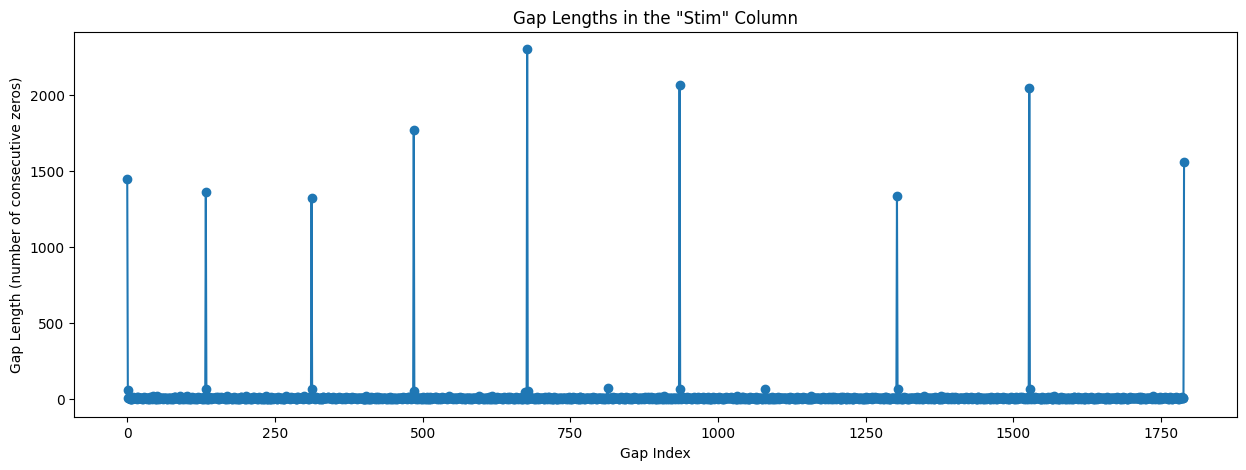

In [10]:
# Identify all the gaps of '0's
gaps = df['stim'] == 0
gap_lengths = []
gap_indices = []  # To store the start and end indices of each gap
current_gap_length = 0
start_index = None  # To track the start of a gap

# Calculate the length of each gap and their start and end indices
for i, is_gap in enumerate(gaps):
    if is_gap:
        current_gap_length += 1
        if current_gap_length == 1:
            start_index = i  # Mark the start of a new gap
    elif current_gap_length != 0:
        gap_lengths.append(current_gap_length)
        gap_indices.append((start_index, i - 1))  # Store start and end index of the gap
        current_gap_length = 0

# Add the last gap if it ends at the end of the dataset
if current_gap_length != 0:
    gap_lengths.append(current_gap_length)
    gap_indices.append((start_index, len(gaps) - 1))  # End index is the last index of the DataFrame

# Convert gap_lengths to a DataFrame for analysis
gap_lengths_df = pd.DataFrame({
    'Length': gap_lengths,
    'Index_Range': gap_indices
})

# Calculate statistics to find significant gaps
mean_length = gap_lengths_df['Length'].mean()
std_dev = gap_lengths_df['Length'].std()

# Define a threshold for significant gaps
threshold = mean_length + 0.1 * std_dev # The threshold is rather strict to ensure that 

# Identify significant gaps
significant_gaps = gap_lengths_df[gap_lengths_df['Length'] > threshold]

print("Mean gap length:", mean_length)
print("Standard deviation of gap lengths:", std_dev)
print("Threshold for significant gaps:", threshold)
print("Significant gaps found:", len(significant_gaps))
print(significant_gaps)

# Plot the gap lengths
plt.figure(figsize=(15, 5))
plt.plot(gap_lengths, marker='o', linestyle='-')
plt.title('Gap Lengths in the "Stim" Column')
plt.xlabel('Gap Index')
plt.ylabel('Gap Length (number of consecutive zeros)')
plt.show()

In [11]:
# fill all gaps
df['filled_stim'] = df['stim'].copy()
df['filled_stim'] = df['filled_stim'].replace(0, pd.NA)
pd.set_option('future.no_silent_downcasting', True)
df['filled_stim'] = df['filled_stim'].ffill().bfill()
df['filled_stim'] = df['filled_stim'].fillna(0)

# ensure significant gaps remain zero
for _, row in significant_gaps.iterrows():
    start_index = row["Index_Range"][0]
    end_index = row["Index_Range"][1]
    df.loc[start_index:end_index, 'filled_stim'] = 0

# remove rows with all 0 for _filt columns ['Fz_filt', 'C3_filt', 'Cz_filt', 'C4_filt', 'Pz_filt', 'PO7_filt', 'Oz_filt', 'PO8_filt']
filt_cols = [col for col in df.columns if col.endswith('_filt')]
df = df[~df[filt_cols].eq(0).all(axis=1)]

print(df.head())

file_path_parts = file_path.rsplit('.', 1)
new_file_path = file_path_parts[0] + '_cleaned.' + file_path_parts[1]
df.to_csv(new_file_path) 

print(f"Reformatted data saved to {new_file_path}")

        timestamps          converted_timestamps             Fz  \
1259  1.714099e+09 2024-04-26 02:39:11.158737183  205457.062500   
1260  1.714099e+09 2024-04-26 02:39:11.165599108  205443.562500   
1262  1.714099e+09 2024-04-26 02:39:11.177425623  205445.531250   
1263  1.714099e+09 2024-04-26 02:39:11.179912806  205460.734375   
1264  1.714099e+09 2024-04-26 02:39:11.179963589  205453.578125   

                 C3             Cz             C4             Pz  \
1259  201497.500000  212197.093750  252553.359375  200033.015625   
1260  201493.828125  212184.578125  252540.843750  200018.890625   
1262  201486.687500  212185.203125  252541.546875  200021.843750   
1263  201500.093750  212201.843750  252553.265625  200038.562500   
1264  201505.546875  212197.453125  252545.046875  200031.671875   

                PO7             Oz            PO8        Fz_filt  \
1259  197339.890625  201942.828125  198446.750000  113567.322657   
1260  197344.812500  201957.937500  198444.078125   